# Предсказание финального места в игре PUBG

Работу выполнили студенты 2 курса Высшей школы ИТИС Хабибрахманов Рустем и Хамдамов Отабек, группа 11-811.

**Описание**: в игре PUBG в каждом матче играет до 100 игроков. Игроки могут быть в командах, которые получают рейтинг в конце игры на основе того, сколько других команд еще живы и когда они выбывают. В игре игроки могут подбирать различные боеприпасы, оживлять сбитых, но не выбитых товарищей по команде, управлять транспортными средствами, плавать, бегать, стрелять.
 
 **Цель**: создать модель, которая предсказывает финальное расположение игроков на основе их статистики, по шкале 1 (первое место) до 0 (последнее место).
 
 Ссылка на датасет: 

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [8]:
dataset = pd.read_csv(r'C:\Users\ruste\Desktop\train_V2.csv')
dataset.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


**Описание датасета**:

**Id** - идентификатор игрока.

**groupId** - идетнификатор группы для одного матча. Если одна и та же группа игроков играет в разных матчах, у них каждый раз будет другой groupId.

**matchId** - идентификатор матча.

**assists** - количество вражеских игроков, которых этот игрок повредил и которые были убиты товарищами по команде.

**boosts** - количество используемых элементов усиления.

**damageDealt** - общий нанесенный урон.

**DBNOs** - количество выбитых вражеских игроков.

**headshotKills** - количество вражеских игроков, убитых выстрелами в голову.

**heals** - количество используемых лечебных предметов.

**killPlace** - рейтинг в матче по количеству убитых вражеских игроков.

**killPoints** - рейтинг игрока на основе убийств.

**kills** - количество убитых вражеских игроков.

**killStreaks** - максимальное количество вражеских игроков, убитых за короткий промежуток времени.

**longestKill** - самое большое расстояние между игроком и игроком, убитым в момент смерти.

**matchDuration** - длительность матча в секундах.

**matchType** - строка, идентифицирующая игровой режим. Стандартные режимы - "solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp” и "squad-fpp"

**maxPlace** - наихудшее занятое место за все время

**numGroups** - количество групп, для которых у нас есть данные в матче.

**rankPoints** - Эло-подобный рейтинг игрока.

**revives** - количество раз, когда этот игрок оживлял товарищей по команде.

**rideDistance** - общее расстояние, пройденное в транспортных средствах, измеряемое в метрах.

**roadKills** - количество убийств, совершаемых в автомобиле.

**swimDistance** - общее расстояние, пройденное плаванием, измеряемое в метрах.

**teamKills** - количество раз, когда этот игрок убивал товарища по команде.

**vehicleDestroys** - количество уничтоженных транспортных средств.

**walkDistance** - общее расстояние, пройденное пешком, измеряемое в метрах.

**weaponsAcquired** - количество подобранного оружия.

**winPoints** - рейтинг игрока, основанный на победах (похож на Эло-рейтинг).

**winPlacePerc** - 

In [7]:
dataset.shape

(1934174, 28)

In [11]:
dataset.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [13]:
dataset.dropna(inplace=True)
dataset.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

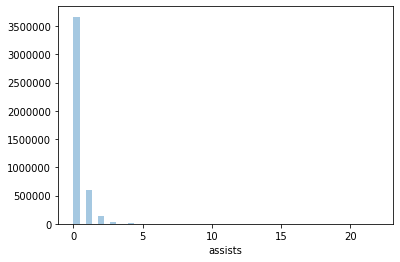

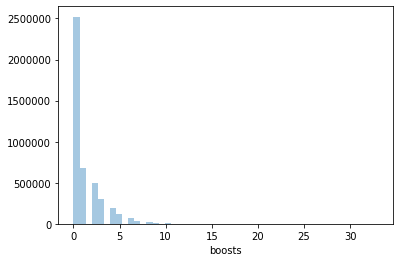

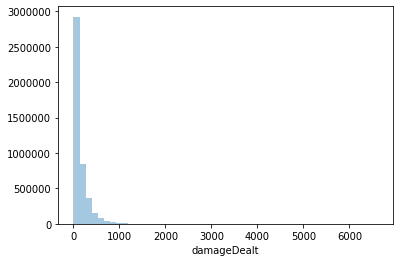

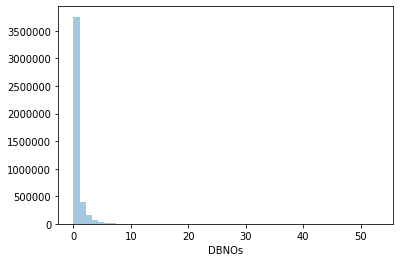

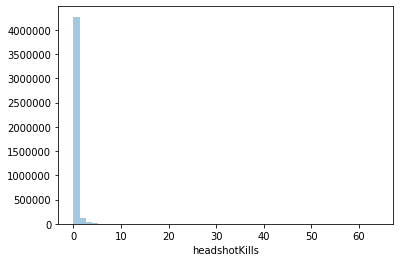

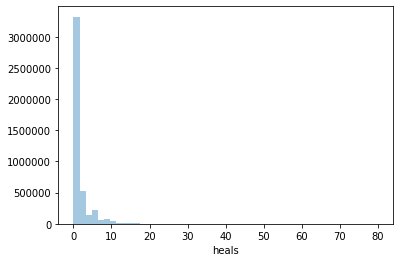

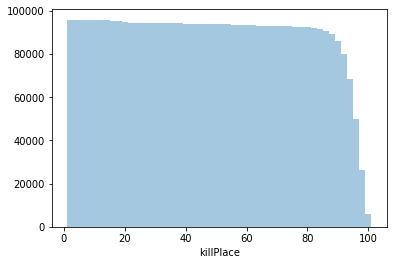

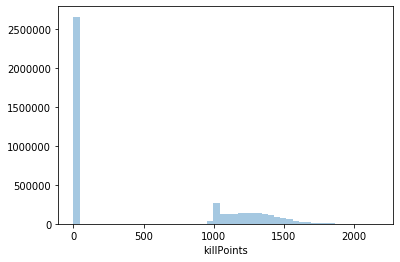

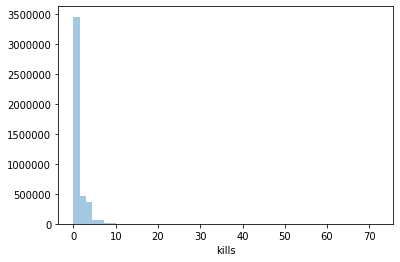

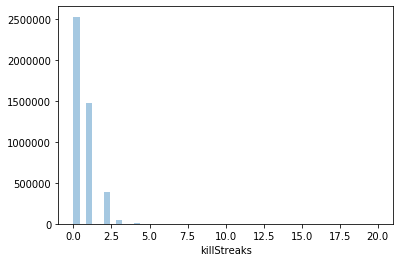

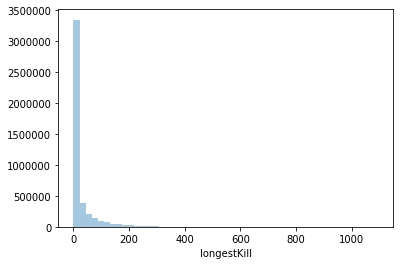

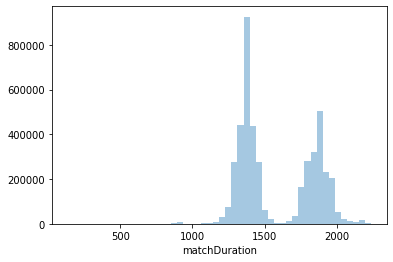

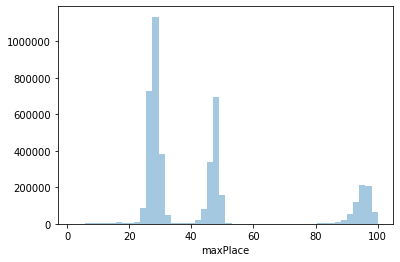

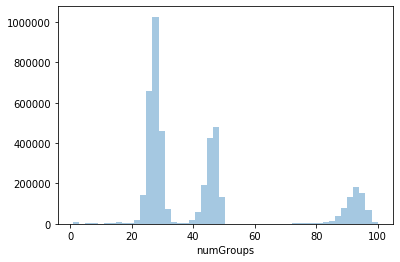

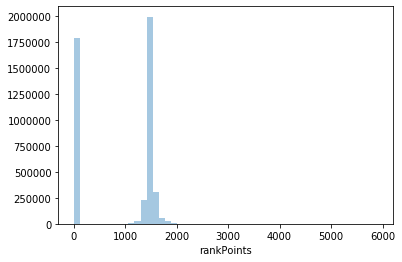

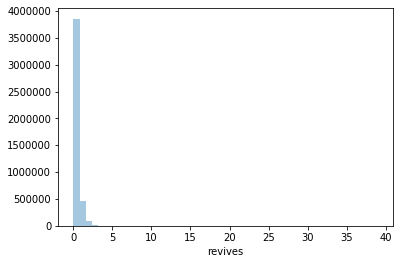

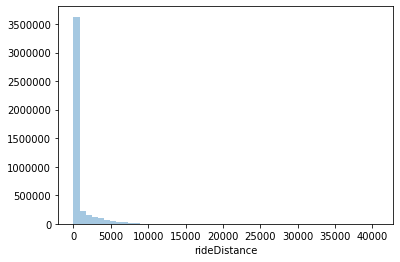

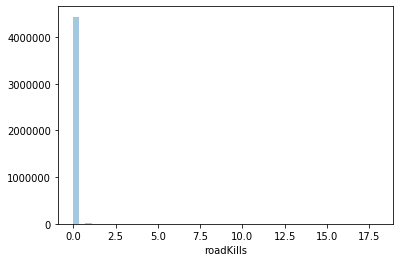

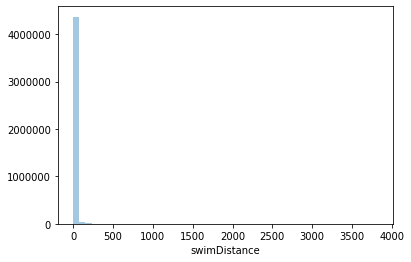

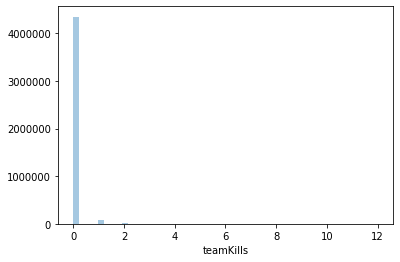

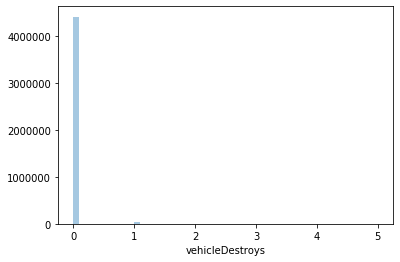

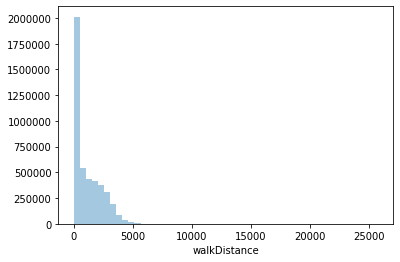

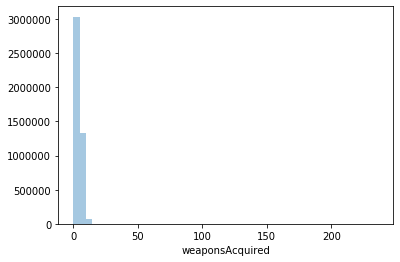

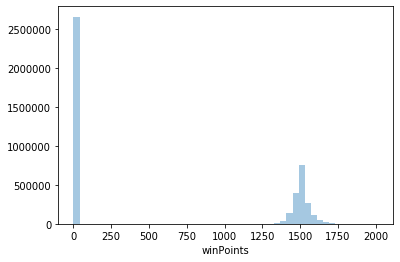

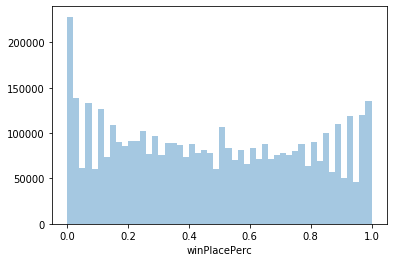

In [14]:
for i in dataset.var().index:
    sns.distplot(dataset[i],kde=False)
    plt.show()

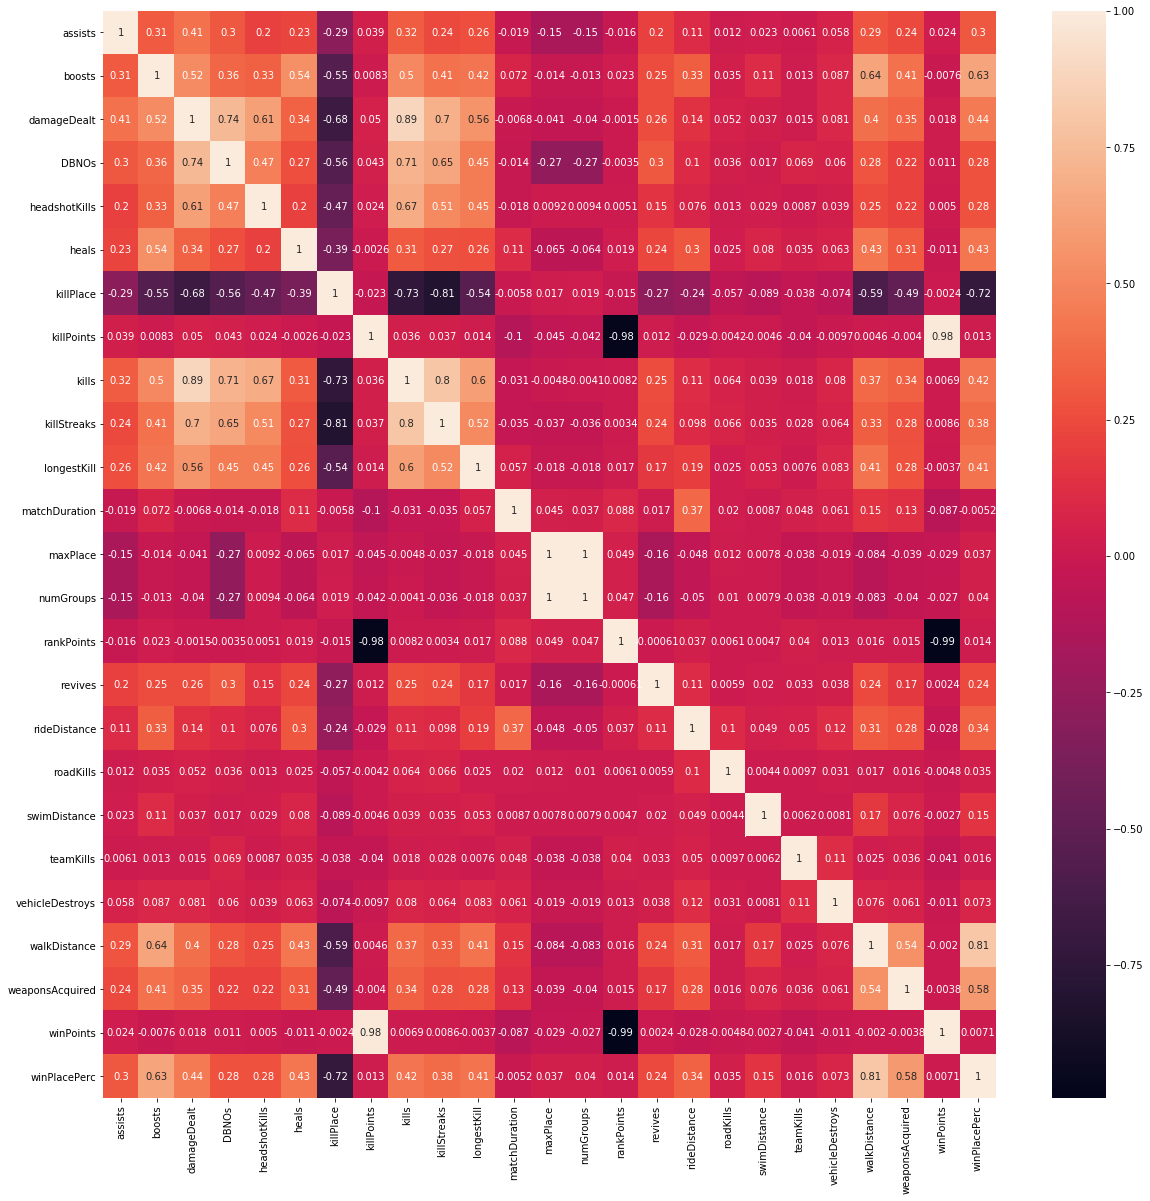

In [18]:
plt.figure(figsize=(20, 20))
correlation_matrix = dataset.corr()  
sns.heatmap(correlation_matrix, annot=True)
plt.show()